In [ ]:
## TODO
## subclass nx.graph and store adj, D, etc as attribute variables
## Grabriel quality

In [1]:
## custom
from utils import utils, vis
from utils import poly_point_isect as bo   ##bentley-ottmann sweep line
import criteria as C
import quality as Q
import gd2


## third party
import networkx as nx

from PIL import Image
from natsort import natsorted


## sys
import random
import time
from glob import glob
import math
from collections import defaultdict
import os
from pathlib import Path


## numeric
import numpy as np
import scipy.io as io
import torch
from torch import nn, optim
import torch.nn.functional as F


## vis
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from IPython.display import clear_output
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')


## Optimize via Stochastic Gradient Descent (SGD)

In [2]:
# delete old
# !rm -r figures
# !mkdir figures

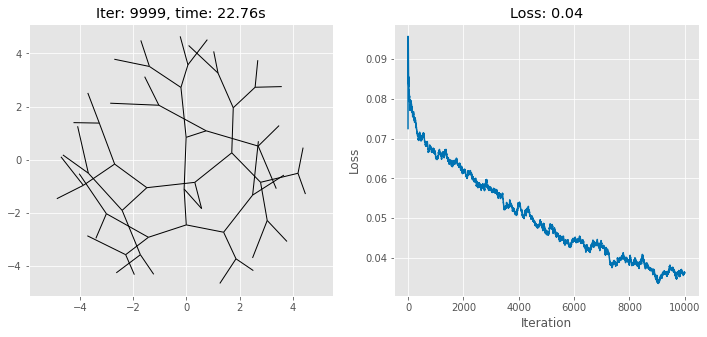

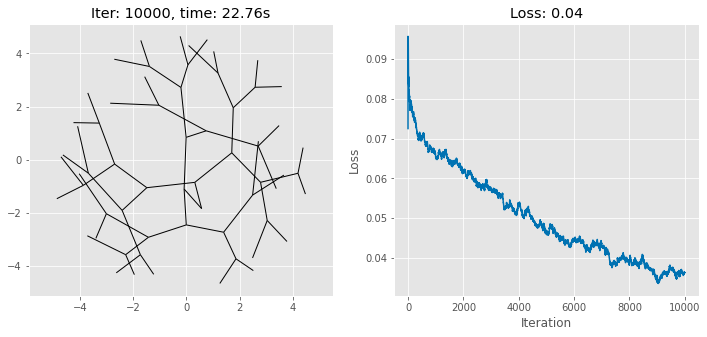

CPU times: user 2min 25s, sys: 1.65 s, total: 2min 26s
Wall time: 26.6 s


In [294]:
%%time


import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2


##choose a graph
G = nx.balanced_tree(2,5)
# G = nx.grid_2d_graph(6,15)
# G = nx.hypercube_graph(4)
# G = utils.load_spx_teaser()
# G = nx.karate_club_graph()

# graph_name = 'grid1'
# graph_name = 'grid1_dual'
# graph_name = 'odepa400'
# graph_name = 'netz4504_dual'
# graph_name = 'L'
# -----
# graph_name = 'netz4504'
# graph_name = 'qh882'
# mat_dir = 'graphs/SuiteSparse Matrix Collection'
# G = utils.load_mat(f'{mat_dir}/{graph_name}.mat')


# G = nx.Graph()
# G.add_nodes_from([0,1,2,3])
# G.add_edges_from([(0,1),(2,3)])




## choose criteria
criteria_pair = {'stress', 'aspect_ratio'}



criteria_weights = dict(
    stress=0.1,
    edge_uniformity=0.01,
    neighborhood_preservation=0.5,
    crossings=0.9,
    crossing_angle_maximization=0.1,
    aspect_ratio=0.9,
    angular_resolution=0.1,
    vertex_resolution=0.99,
    gabriel=0.5,
)

sample_sizes = dict(
    stress=64,
    edge_uniformity=int(len(G)**0.5),
    neighborhood_preservation=16,
    crossings=16,
    crossing_angle_maximization=10,
    aspect_ratio=int(len(G)**0.5),
    angular_resolution=32,
    vertex_resolution=int(len(G)**0.5),
    gabriel=10,
)

gd = GD2(G)

result = gd.optimize(
    criteria_weights={c:criteria_weights[c] for c in criteria_pair}, 
    sample_sizes=sample_sizes,
    
#     evaluate='all',
#     evaluate={'stress'},    
#     evaluate={'angular_resolution'},
#     evaluate={'neighborhood_preservation'},
#     evaluate={'crossing_angle_maximization'},
    evaluate=criteria_pair,
    
    max_iter=10000, 
    evaluate_interval=10000//40,
    vis_interval=10000//20,
    clear_output=True,
    
    optimizer_kwargs = dict(lr=1),
    scheduler_kwargs = dict(verbose=True),
)

pos = gd.pos.detach().numpy()
pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
vis.plot(
    gd.G, pos_G,
    gd.loss_curve, 
    result['iter'], result['runtime'],
    edge=True, show=True, save=False
)



(0.0, 1.1)

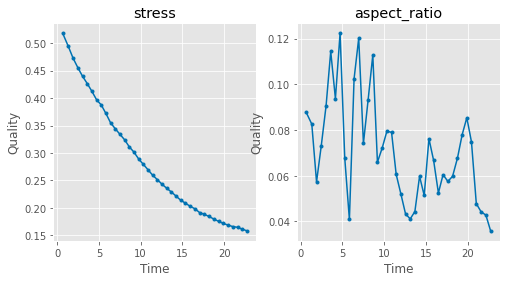

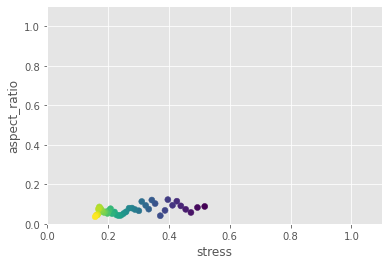

In [295]:
qx, qy = criteria_pair

t = [r['time'] for r in gd.qualities_by_time]
quality_curve_x = [r['qualities'][qx] for r in gd.qualities_by_time]
quality_curve_y = [r['qualities'][qy] for r in gd.qualities_by_time]

plt.figure(figsize=[8,4])
plt.subplot(121)
plt.plot(t, quality_curve_x, '.-')
plt.title(qx)
plt.xlabel('Time')
plt.ylabel('Quality')

plt.subplot(122)
plt.plot(t, quality_curve_y, '.-')
plt.title(qy)
plt.xlabel('Time')
plt.ylabel('Quality')

plt.figure()
# plt.plot(quality_curve_x, quality_curve_y, '--', c='#777777', zorder=-1)
plt.scatter(quality_curve_x, quality_curve_y, c=np.arange(len(quality_curve_x)))
plt.xlabel(qx)
plt.ylabel(qy)
plt.xlim([0, max(max(quality_curve_x), 1.1)])
plt.ylim([0, max(max(quality_curve_y)*1.05, 1.1)])


## Example matrix

In [84]:
# !mkdir -p ./analysis/pairs

In [39]:
##todo move it to GD2.py

import pickle as pkl

def dump(gd, fn='result.pkl'):
    with open(fn, 'wb') as f:
        pkl.dump(dict(
            G=gd.G,
            pos=gd.pos,
            i2k=gd.i2k,
            k2i=gd.k2i,
            iter=gd.i,
            runtime=gd.runtime,
            loss_curve=gd.loss_curve,
            qualities_by_time = gd.qualities_by_time,
        ), f)

In [296]:
##choose a graph
G = nx.balanced_tree(2,5)
graph_str = 'tree_2_5'

# G = nx.grid_2d_graph(15,10)
# graph_str = 'grid_15_10'

start_date = int(time.time())
dir_out = f'./analysis/criteria_pairs/{graph_str}-t{start_date}'
print(dir_out)
if not Path(dir_out).exists():
    os.makedirs(dir_out)

./analysis/criteria_pairs/tree_2_5-t1633999851


{'stress'}



{'stress': 0.07015283633462911, 'edge_uniformity': 0.07298988103866577, 'neighborhood_preservation': 0.5664739906787872, 'crossings': 1, 'crossing_angle_maximization': 0.05357691454146935, 'aspect_ratio': 0.21914565563201904, 'angular_resolution': 0.9978799661621451, 'vertex_resolution': 0.5602707808392354, 'gabriel': 0.7794215083122253}


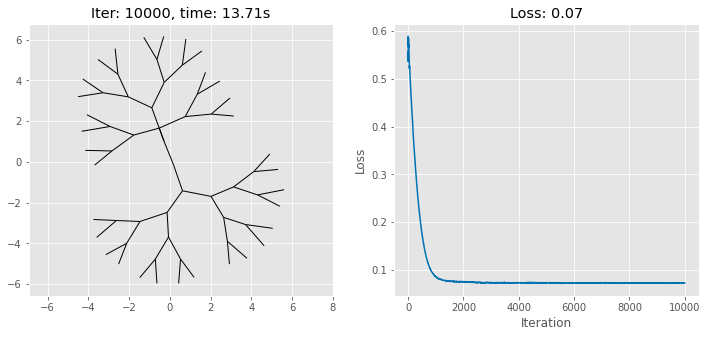

{'edge_uniformity', 'stress'}



{'stress': 0.06730443247237115, 'edge_uniformity': 0.07385744899511337, 'neighborhood_preservation': 0.6067415773868561, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.18762969970703125, 'angular_resolution': 0.7744121700525284, 'vertex_resolution': 0.6444167663899347, 'gabriel': 0.17436754703521729}


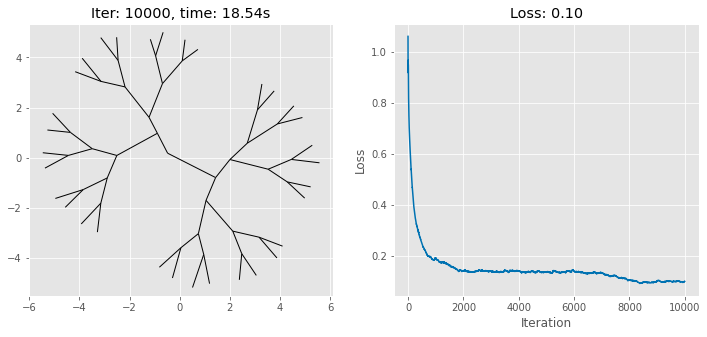

{'neighborhood_preservation', 'stress'}



{'stress': 0.09465413617204561, 'edge_uniformity': 0.27025529742240906, 'neighborhood_preservation': 0.2158273458480835, 'crossings': 1, 'crossing_angle_maximization': 0.2188056412982939, 'aspect_ratio': 0.22240537405014038, 'angular_resolution': 0.6074775159358978, 'vertex_resolution': 0.7264471387552192, 'gabriel': 0.511740118265152}


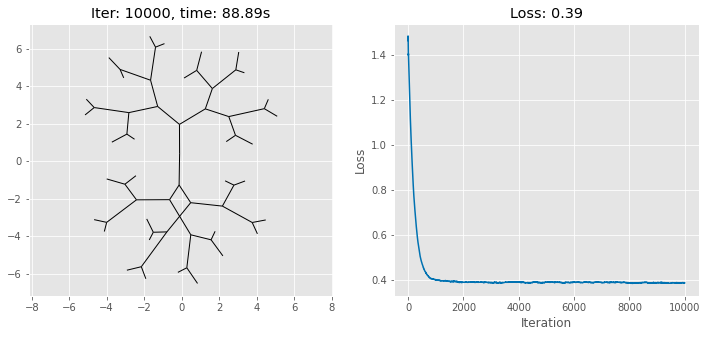

{'stress', 'crossings'}



{'stress': 0.058974771948331325, 'edge_uniformity': 0.06012531369924545, 'neighborhood_preservation': 0.5238095223903656, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.17948824167251587, 'angular_resolution': 0.6965402960777283, 'vertex_resolution': 0.5123163977579104, 'gabriel': 5.364418029785156e-07}


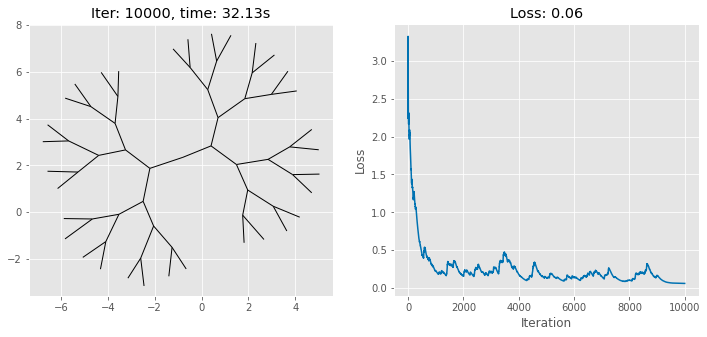

{'stress', 'crossing_angle_maximization'}



{'stress': 0.06196753357793368, 'edge_uniformity': 0.07416623085737228, 'neighborhood_preservation': 0.5988700687885284, 'crossings': 3, 'crossing_angle_maximization': 0.013436272244258305, 'aspect_ratio': 0.18301856517791748, 'angular_resolution': 0.9987938028061762, 'vertex_resolution': 0.691381703493929, 'gabriel': 0.6782439053058624}


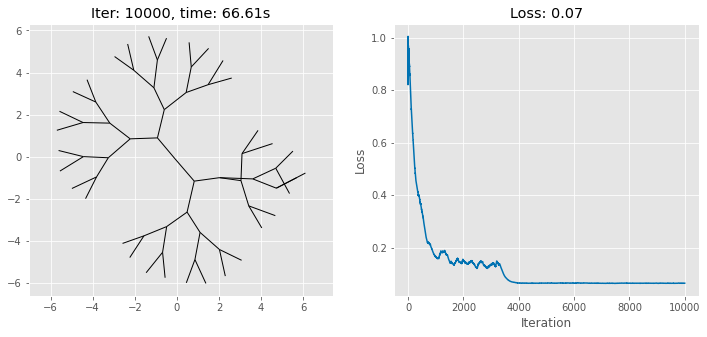

{'stress', 'aspect_ratio'}



{'stress': 0.07988617460839062, 'edge_uniformity': 0.21162475645542145, 'neighborhood_preservation': 0.5664739906787872, 'crossings': 5, 'crossing_angle_maximization': 0.9545483822137037, 'aspect_ratio': 0.06795394420623779, 'angular_resolution': 0.9741229750216007, 'vertex_resolution': 0.9279216311534714, 'gabriel': 0.7874810099601746}


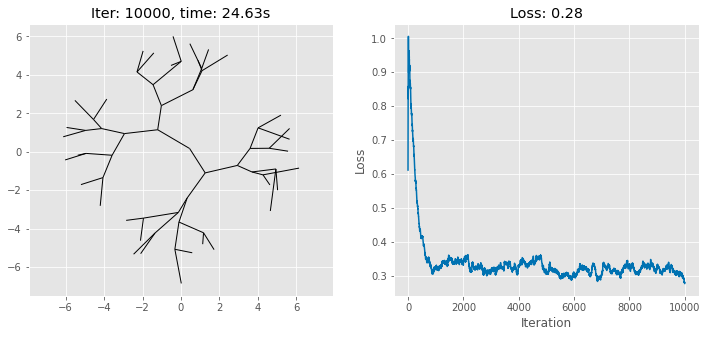

{'stress', 'angular_resolution'}



{'stress': 0.06539336831999276, 'edge_uniformity': 0.07728776335716248, 'neighborhood_preservation': 0.5060240924358368, 'crossings': 4, 'crossing_angle_maximization': 0.20198531388425742, 'aspect_ratio': 0.16481363773345947, 'angular_resolution': 0.36543071269989014, 'vertex_resolution': 0.6767823922578025, 'gabriel': 0.4894447922706604}


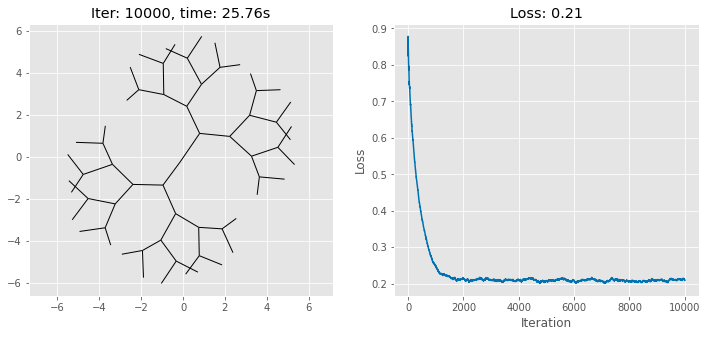

{'stress', 'vertex_resolution'}



{'stress': 0.05871941233818106, 'edge_uniformity': 0.06821513921022415, 'neighborhood_preservation': 0.5411764681339264, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.18073225021362305, 'angular_resolution': 0.6824577450752258, 'vertex_resolution': 0.5131630640227125, 'gabriel': 4.172325134277344e-07}


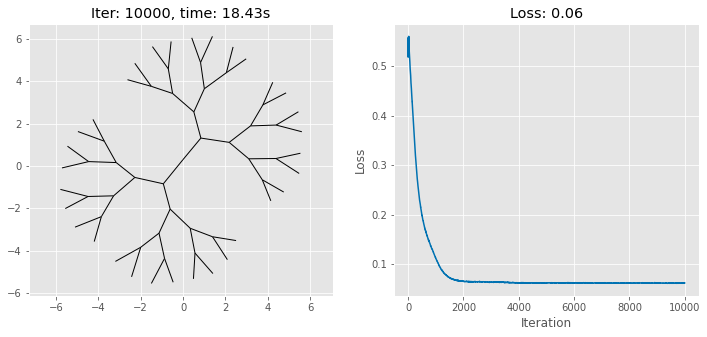

{'gabriel', 'stress'}



{'stress': 0.05864047426576347, 'edge_uniformity': 0.059485550969839096, 'neighborhood_preservation': 0.5581395328044891, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.16912215948104858, 'angular_resolution': 0.6967979371547699, 'vertex_resolution': 0.4917640310502086, 'gabriel': 4.172325134277344e-07}


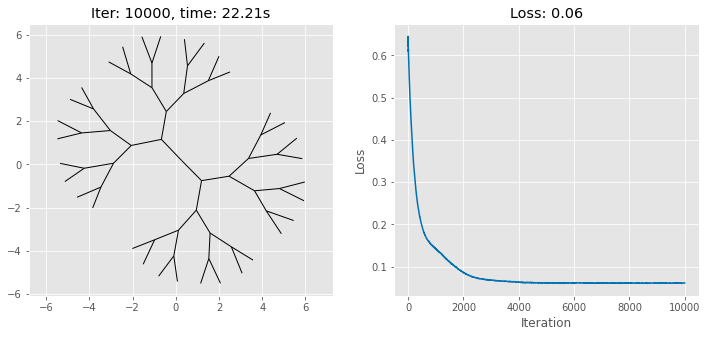

{'edge_uniformity'}



{'stress': 0.6078651720172922, 'edge_uniformity': 0.0, 'neighborhood_preservation': 0.9959514169022441, 'crossings': 289, 'crossing_angle_maximization': 0.939362291395079, 'aspect_ratio': 0.21996480226516724, 'angular_resolution': 0.9949197052046657, 'vertex_resolution': 0.9787490647037118, 'gabriel': 0.9660745561122894}


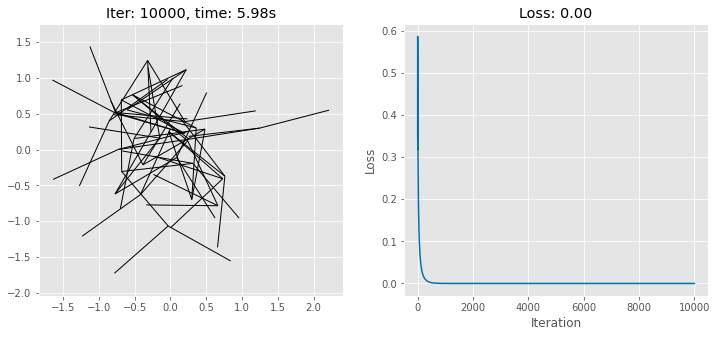

{'neighborhood_preservation', 'edge_uniformity'}



{'stress': 0.10161185922454453, 'edge_uniformity': 0.15661443769931793, 'neighborhood_preservation': 0.34666669368743896, 'crossings': 2, 'crossing_angle_maximization': 0.35131669945688654, 'aspect_ratio': 0.22597402334213257, 'angular_resolution': 0.9917338779196143, 'vertex_resolution': 0.9529885305319041, 'gabriel': 0.6280368566513062}


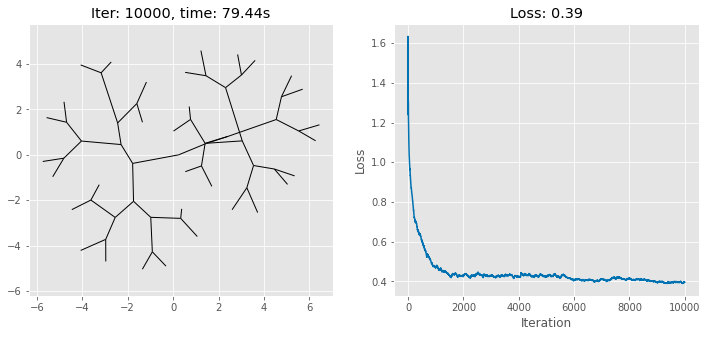

{'edge_uniformity', 'crossings'}



{'stress': 0.15051213929613408, 'edge_uniformity': 4.2978416558980825e-07, 'neighborhood_preservation': 0.5909090936183929, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.16827446222305298, 'angular_resolution': 0.9977397196926177, 'vertex_resolution': 0.9623708604782092, 'gabriel': 0.14449167251586914}


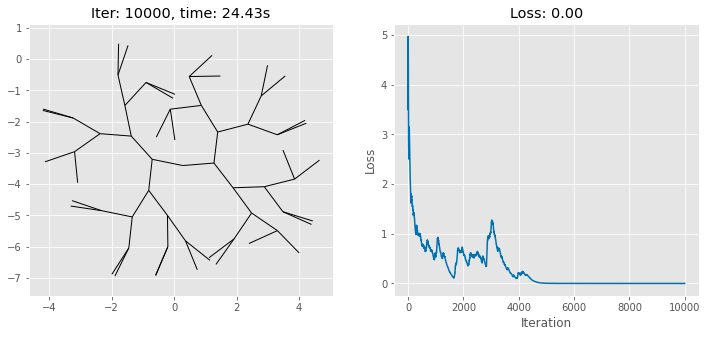

{'edge_uniformity', 'crossing_angle_maximization'}



{'stress': 0.6521429768194708, 'edge_uniformity': 0.09028354287147522, 'neighborhood_preservation': 1.0, 'crossings': 420, 'crossing_angle_maximization': 0.9860790398251783, 'aspect_ratio': 0.10940802097320557, 'angular_resolution': 0.9911875762045383, 'vertex_resolution': 0.9204652873258763, 'gabriel': 0.9593579210340977}


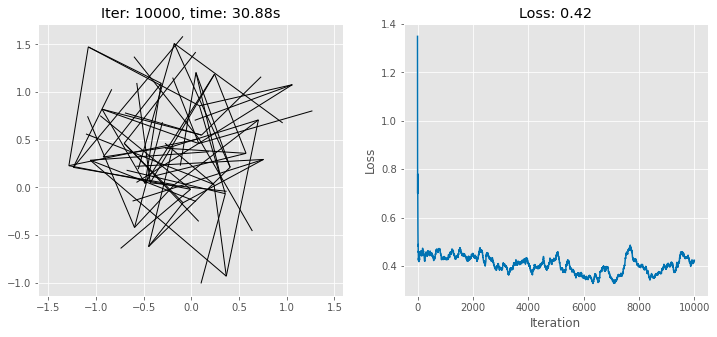

{'edge_uniformity', 'aspect_ratio'}



{'stress': 0.1380619970111569, 'edge_uniformity': 0.16910718381404877, 'neighborhood_preservation': 0.83568075299263, 'crossings': 34, 'crossing_angle_maximization': 0.8484961867528974, 'aspect_ratio': 0.09042853116989136, 'angular_resolution': 0.9694693963974714, 'vertex_resolution': 0.9171753594285326, 'gabriel': 0.9002587869763374}


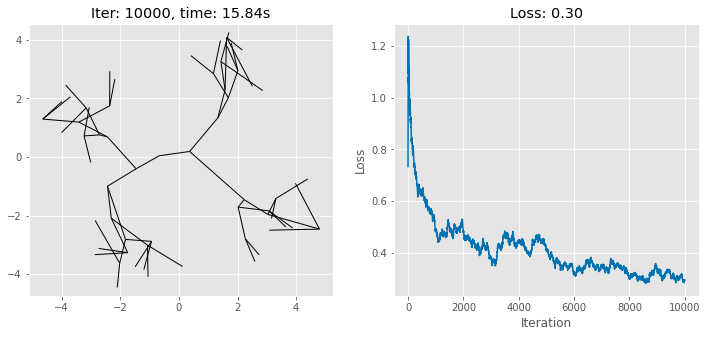

{'edge_uniformity', 'angular_resolution'}



{'stress': 0.25667245520030263, 'edge_uniformity': 0.00025931597338058054, 'neighborhood_preservation': 0.8727272748947144, 'crossings': 24, 'crossing_angle_maximization': 0.9550344640096363, 'aspect_ratio': 0.24289685487747192, 'angular_resolution': 0.40932363271713257, 'vertex_resolution': 0.9795818509965726, 'gabriel': 0.8663491159677505}


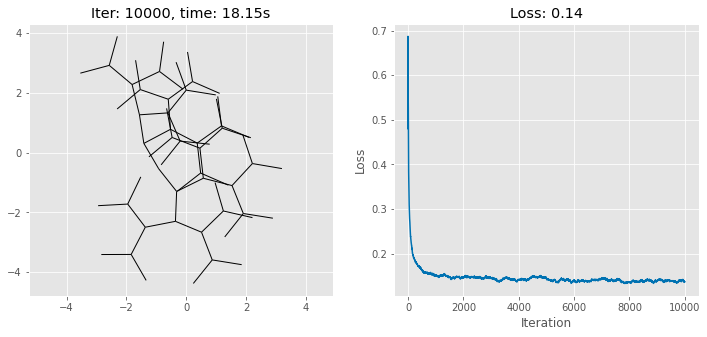

{'edge_uniformity', 'vertex_resolution'}



{'stress': 0.3892152033664735, 'edge_uniformity': 0.007914031855762005, 'neighborhood_preservation': 0.9918699190020561, 'crossings': 49, 'crossing_angle_maximization': 0.9321025592172633, 'aspect_ratio': 0.1724204421043396, 'angular_resolution': 0.9639603942632675, 'vertex_resolution': 0.8946482826918629, 'gabriel': 0.940711110830307}


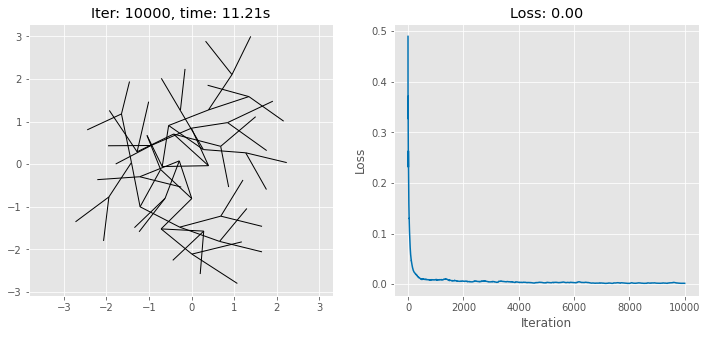

{'edge_uniformity', 'gabriel'}



{'stress': 0.5823893984606386, 'edge_uniformity': 5.385851977735001e-07, 'neighborhood_preservation': 0.9959514169022441, 'crossings': 142, 'crossing_angle_maximization': 1.0000000278275352, 'aspect_ratio': 0.23785966634750366, 'angular_resolution': 0.9999875918229009, 'vertex_resolution': 0.9778585939313051, 'gabriel': 0.057538628578186035}


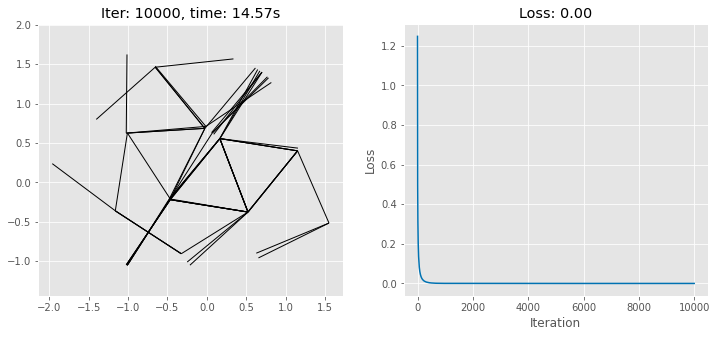

{'neighborhood_preservation'}



{'stress': 0.17970667746766844, 'edge_uniformity': 0.7655296921730042, 'neighborhood_preservation': 0.1764705777168274, 'crossings': 4, 'crossing_angle_maximization': 0.8038784313457338, 'aspect_ratio': 0.3341582417488098, 'angular_resolution': 0.6297970414161682, 'vertex_resolution': 0.7831418777523813, 'gabriel': 0.9223560690879822}


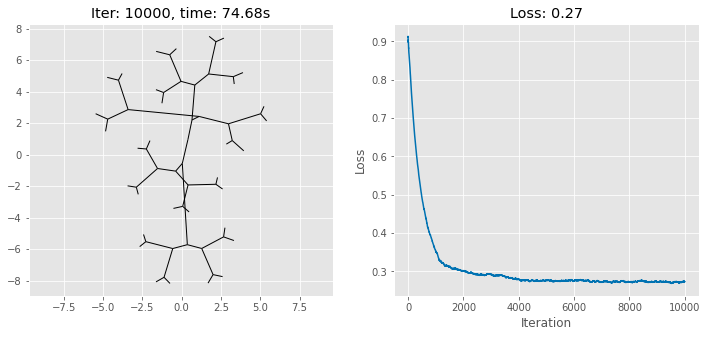

{'neighborhood_preservation', 'crossings'}



{'stress': 0.12174002761110767, 'edge_uniformity': 0.5022222399711609, 'neighborhood_preservation': 0.12121212482452393, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.2037915587425232, 'angular_resolution': 0.32110363245010376, 'vertex_resolution': 0.7702989013559862, 'gabriel': 0.6200989484786987}


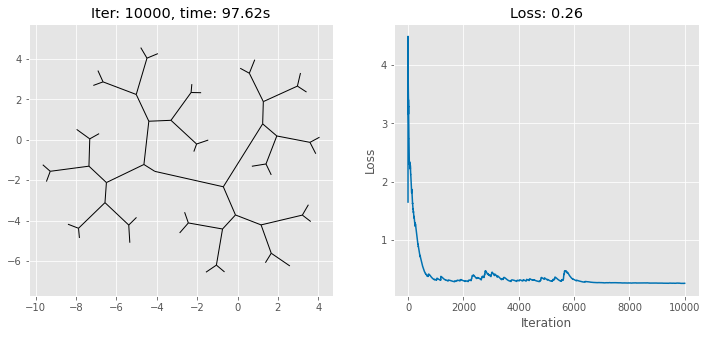

{'neighborhood_preservation', 'crossing_angle_maximization'}



{'stress': 0.1769885246728277, 'edge_uniformity': 0.8445128202438354, 'neighborhood_preservation': 0.2657342553138733, 'crossings': 9, 'crossing_angle_maximization': 0.3376003894566577, 'aspect_ratio': 0.30716419219970703, 'angular_resolution': 0.9634757936000824, 'vertex_resolution': 0.8975720876321674, 'gabriel': 0.514555811882019}


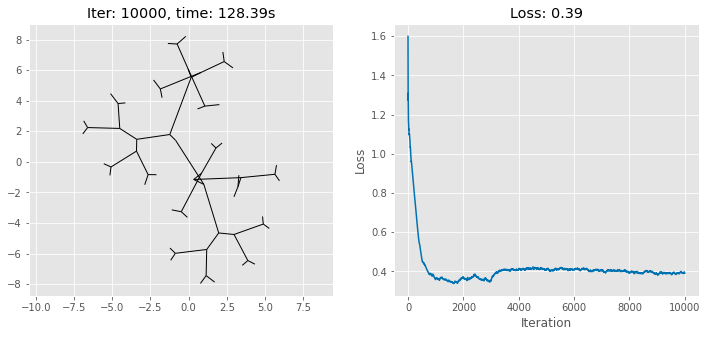

{'neighborhood_preservation', 'aspect_ratio'}



{'stress': 0.36965623485622856, 'edge_uniformity': 1.533483624458313, 'neighborhood_preservation': 0.2158273458480835, 'crossings': 3, 'crossing_angle_maximization': 0.7760209735789013, 'aspect_ratio': 0.07880640029907227, 'angular_resolution': 0.9496838189661503, 'vertex_resolution': 0.8651701288474082, 'gabriel': 0.6198835968971252}


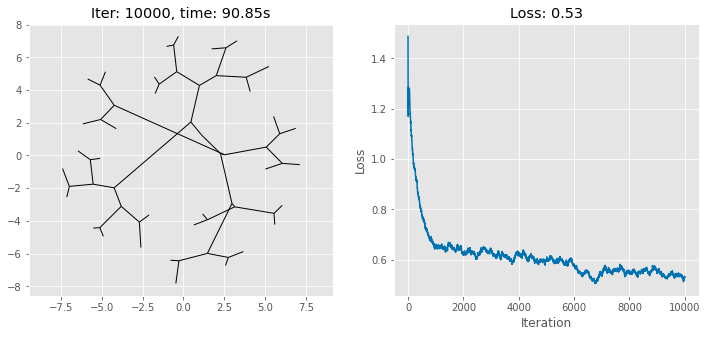

{'neighborhood_preservation', 'angular_resolution'}



{'stress': 0.15294202466659998, 'edge_uniformity': 0.6959331631660461, 'neighborhood_preservation': 0.12121212482452393, 'crossings': 1, 'crossing_angle_maximization': 0.14491665485709598, 'aspect_ratio': 0.3293602466583252, 'angular_resolution': 0.39406317472457886, 'vertex_resolution': 0.7958839821815455, 'gabriel': 0.910437673330307}


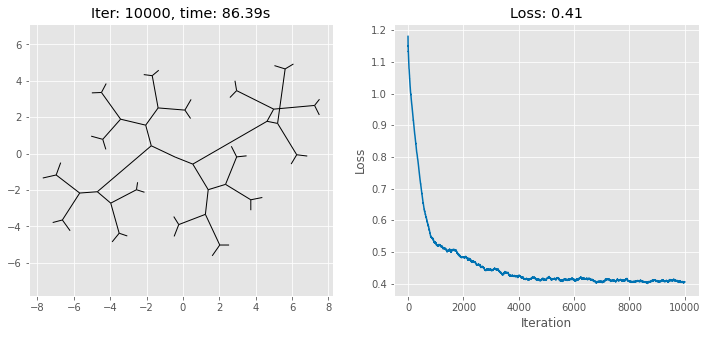

{'neighborhood_preservation', 'vertex_resolution'}



{'stress': 0.27327673140283204, 'edge_uniformity': 1.1837451457977295, 'neighborhood_preservation': 0.22857141494750977, 'crossings': 5, 'crossing_angle_maximization': 0.7692737332618088, 'aspect_ratio': 0.31544238328933716, 'angular_resolution': 0.7181423902511597, 'vertex_resolution': 0.8100269851656678, 'gabriel': 0.9441874474287033}


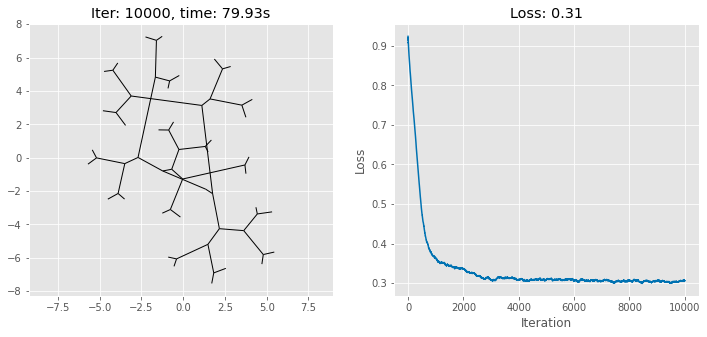

{'neighborhood_preservation', 'gabriel'}



{'stress': 0.2725807824369496, 'edge_uniformity': 1.4837952852249146, 'neighborhood_preservation': 0.301369845867157, 'crossings': 9, 'crossing_angle_maximization': 0.8452442577980636, 'aspect_ratio': 0.19831907749176025, 'angular_resolution': 0.6625563204288483, 'vertex_resolution': 0.8959204380721225, 'gabriel': 0.9711305014789104}


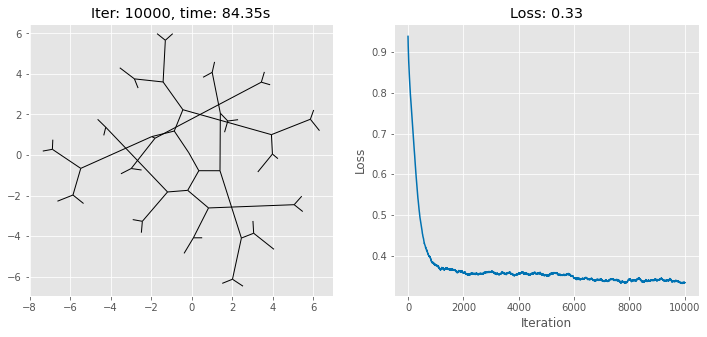

{'crossings'}



{'stress': 1.2539147296778066, 'edge_uniformity': 8.674965858459473, 'neighborhood_preservation': 0.8076923042535782, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.3752182126045227, 'angular_resolution': 0.9882853152230382, 'vertex_resolution': 0.9831381138394882, 'gabriel': 0.7401849925518036}


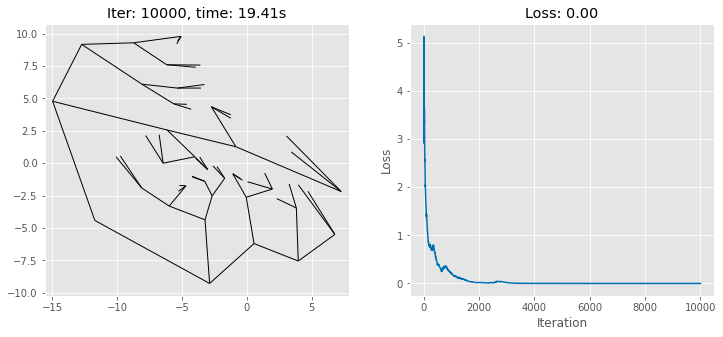

{'crossing_angle_maximization', 'crossings'}



{'stress': 3.8964218994560427, 'edge_uniformity': 23.7188663482666, 'neighborhood_preservation': 0.7411167621612549, 'crossings': 1, 'crossing_angle_maximization': 0.0034160811678864886, 'aspect_ratio': 0.38246262073516846, 'angular_resolution': 0.9867351893335581, 'vertex_resolution': 0.9685117793148651, 'gabriel': 0.8862817287445068}


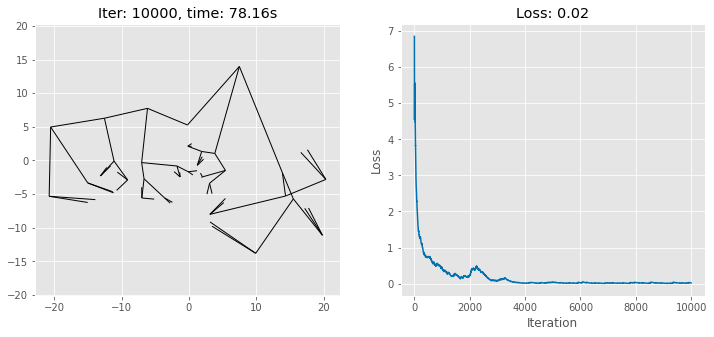

{'aspect_ratio', 'crossings'}



{'stress': 13.918959979822505, 'edge_uniformity': 83.62813568115234, 'neighborhood_preservation': 0.8928571417927742, 'crossings': 9, 'crossing_angle_maximization': 0.932759092178483, 'aspect_ratio': 0.12610012292861938, 'angular_resolution': 0.9866840913891792, 'vertex_resolution': 0.9186827632456179, 'gabriel': 0.9610265828669071}


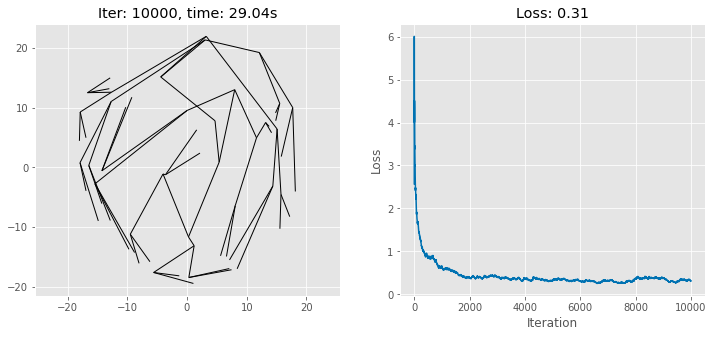

{'angular_resolution', 'crossings'}



{'stress': 10.352037577481438, 'edge_uniformity': 73.42546081542969, 'neighborhood_preservation': 0.6808510720729828, 'crossings': 5, 'crossing_angle_maximization': 0.6537997471869145, 'aspect_ratio': 0.17086893320083618, 'angular_resolution': 0.9270839765667915, 'vertex_resolution': 0.9593066479485527, 'gabriel': 0.8738168478012085}


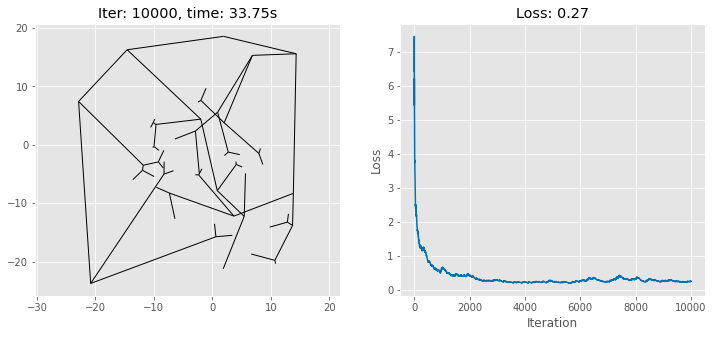

{'vertex_resolution', 'crossings'}



{'stress': 8.152695679534414, 'edge_uniformity': 57.860294342041016, 'neighborhood_preservation': 0.8133971244096756, 'crossings': 4, 'crossing_angle_maximization': 0.509914223221518, 'aspect_ratio': 0.3543689250946045, 'angular_resolution': 0.994860908947885, 'vertex_resolution': 0.9048389020988903, 'gabriel': 0.8374892026185989}


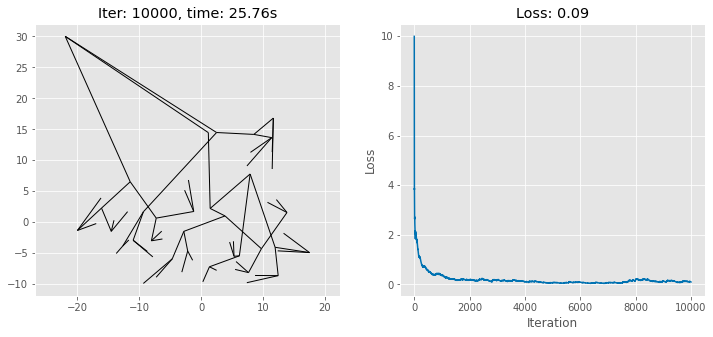

{'gabriel', 'crossings'}



{'stress': 1.6767931786930355, 'edge_uniformity': 8.963011741638184, 'neighborhood_preservation': 0.8727272748947144, 'crossings': 1, 'crossing_angle_maximization': 0.12201518235202478, 'aspect_ratio': 0.28193825483322144, 'angular_resolution': 0.9974850958678871, 'vertex_resolution': 0.9748801487329981, 'gabriel': 0.4719375967979431}


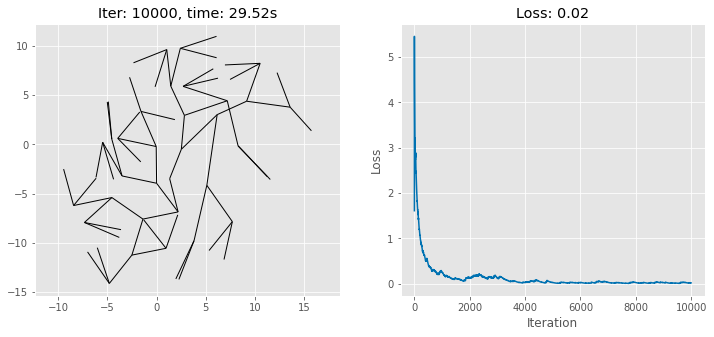

{'crossing_angle_maximization'}



{'stress': 0.6284244241389082, 'edge_uniformity': 7.334856986999512, 'neighborhood_preservation': 0.9918699190020561, 'crossings': 446, 'crossing_angle_maximization': 1.0000000278275352, 'aspect_ratio': 0.19567787647247314, 'angular_resolution': 1.0, 'vertex_resolution': 0.9729551980264114, 'gabriel': 0.9886964960023761}


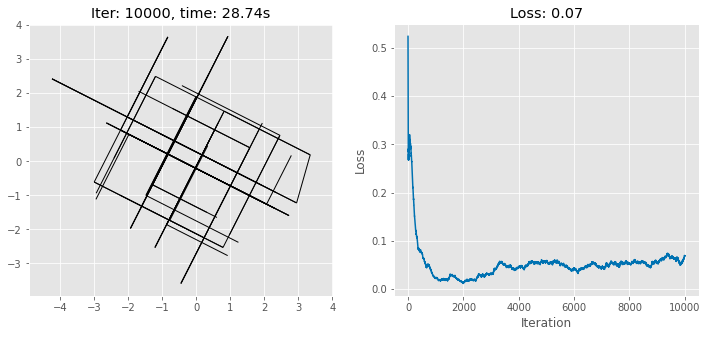

{'aspect_ratio', 'crossing_angle_maximization'}



{'stress': 16.665753974367085, 'edge_uniformity': 268.30010986328125, 'neighborhood_preservation': 0.9666666649281979, 'crossings': 366, 'crossing_angle_maximization': 0.9919119454853784, 'aspect_ratio': 0.08201402425765991, 'angular_resolution': 0.9992680313880555, 'vertex_resolution': 0.978385430943447, 'gabriel': 0.949828889220953}


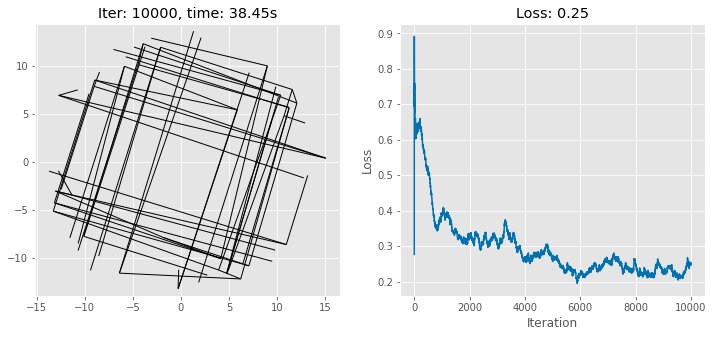

{'angular_resolution', 'crossing_angle_maximization'}



{'stress': 1.018803937811668, 'edge_uniformity': 18.10451316833496, 'neighborhood_preservation': 0.9959514169022441, 'crossings': 428, 'crossing_angle_maximization': 0.9989009744990893, 'aspect_ratio': 0.27595341205596924, 'angular_resolution': 0.9996515465318225, 'vertex_resolution': 0.9706268937651799, 'gabriel': 0.9820007793605328}


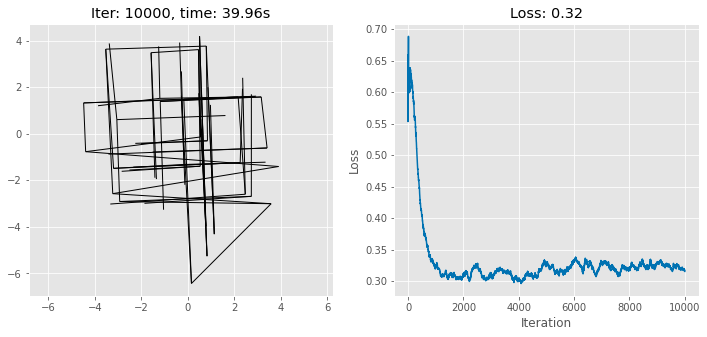

{'vertex_resolution', 'crossing_angle_maximization'}



{'stress': 1.1940545488853864, 'edge_uniformity': 24.885997772216797, 'neighborhood_preservation': 1.0, 'crossings': 491, 'crossing_angle_maximization': 0.9978352373155951, 'aspect_ratio': 0.16823965311050415, 'angular_resolution': 0.9999970046776525, 'vertex_resolution': 0.5538583414676634, 'gabriel': 0.9827991873025894}


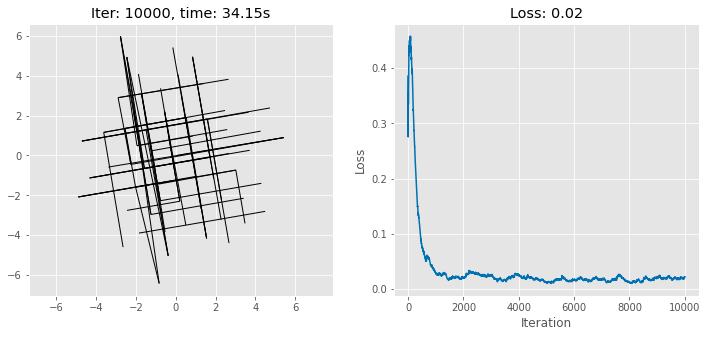

{'gabriel', 'crossing_angle_maximization'}



{'stress': 0.4684522037830098, 'edge_uniformity': 3.9707727432250977, 'neighborhood_preservation': 0.9752066116780043, 'crossings': 246, 'crossing_angle_maximization': 0.9915182989162133, 'aspect_ratio': 0.11982274055480957, 'angular_resolution': 0.9989390439586714, 'vertex_resolution': 0.9882215379807229, 'gabriel': 0.6744353771209717}


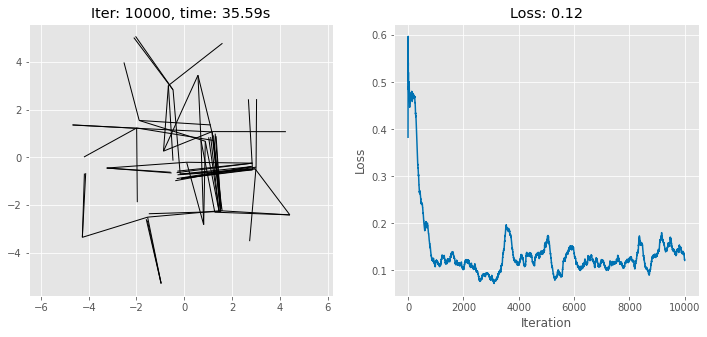

{'aspect_ratio'}



{'stress': 18.816581910709527, 'edge_uniformity': 325.20513916015625, 'neighborhood_preservation': 0.9794238675385714, 'crossings': 536, 'crossing_angle_maximization': 0.9752356591718384, 'aspect_ratio': 0.06048184633255005, 'angular_resolution': 0.9946910077705979, 'vertex_resolution': 0.977702956828227, 'gabriel': 0.8752493932843208}


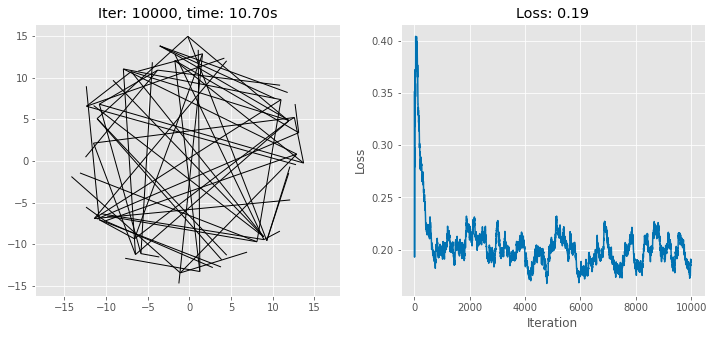

{'angular_resolution', 'aspect_ratio'}



{'stress': 14.993755411649227, 'edge_uniformity': 194.32485961914062, 'neighborhood_preservation': 0.8465116322040558, 'crossings': 256, 'crossing_angle_maximization': 0.9189055712669277, 'aspect_ratio': 0.015223979949951172, 'angular_resolution': 0.8668381869792938, 'vertex_resolution': 0.9213488330301498, 'gabriel': 0.8926255106925964}


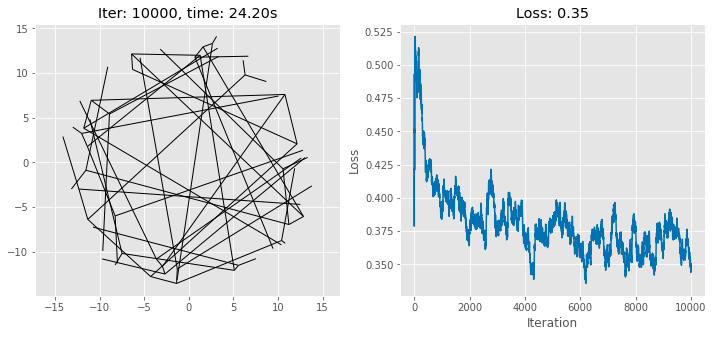

{'vertex_resolution', 'aspect_ratio'}



{'stress': 18.203711178165015, 'edge_uniformity': 318.50396728515625, 'neighborhood_preservation': 0.9794238675385714, 'crossings': 569, 'crossing_angle_maximization': 0.9291552566994119, 'aspect_ratio': 0.08161693811416626, 'angular_resolution': 0.9805142115801573, 'vertex_resolution': 0.8129224008084288, 'gabriel': 0.9661500714719296}


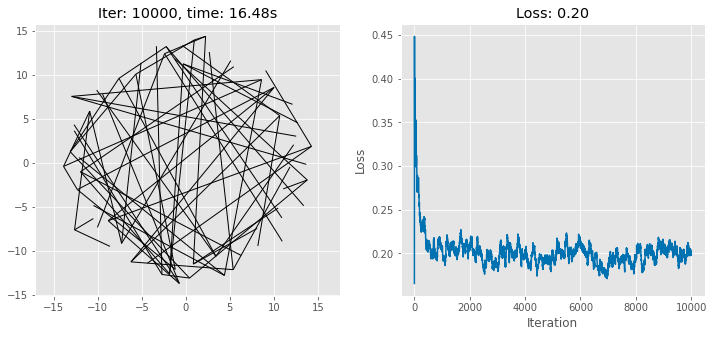

{'gabriel', 'aspect_ratio'}



{'stress': 7.288047637028228, 'edge_uniformity': 62.08097839355469, 'neighborhood_preservation': 1.0, 'crossings': 79, 'crossing_angle_maximization': 0.9878309833472866, 'aspect_ratio': 0.15743380784988403, 'angular_resolution': 0.9969146328512579, 'vertex_resolution': 0.9843675450014184, 'gabriel': 0.29219168424606323}


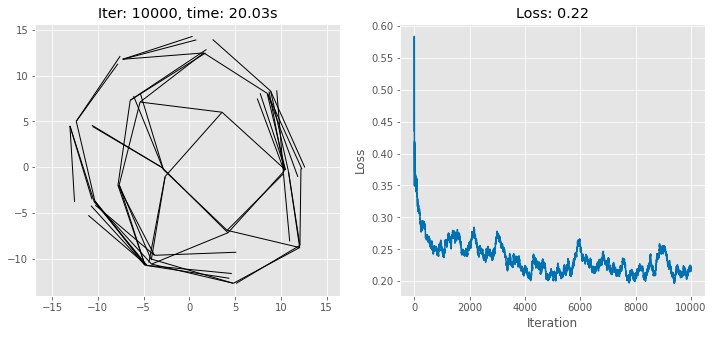

{'angular_resolution'}



{'stress': 0.3953629043318623, 'edge_uniformity': 1.3368784189224243, 'neighborhood_preservation': 0.8828828856348991, 'crossings': 82, 'crossing_angle_maximization': 0.909572876676013, 'aspect_ratio': 0.11238789558410645, 'angular_resolution': 0.9827796146273613, 'vertex_resolution': 0.9653759921337283, 'gabriel': 0.9540932141244411}


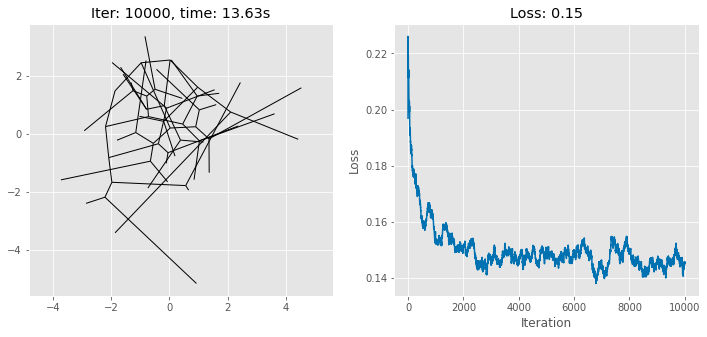

{'vertex_resolution', 'angular_resolution'}



{'stress': 0.5789464840384453, 'edge_uniformity': 6.158277988433838, 'neighborhood_preservation': 0.9122807011008263, 'crossings': 132, 'crossing_angle_maximization': 0.9395536884738209, 'aspect_ratio': 0.11239016056060791, 'angular_resolution': 0.5325547754764557, 'vertex_resolution': 0.6210593761705765, 'gabriel': 0.9584681540727615}


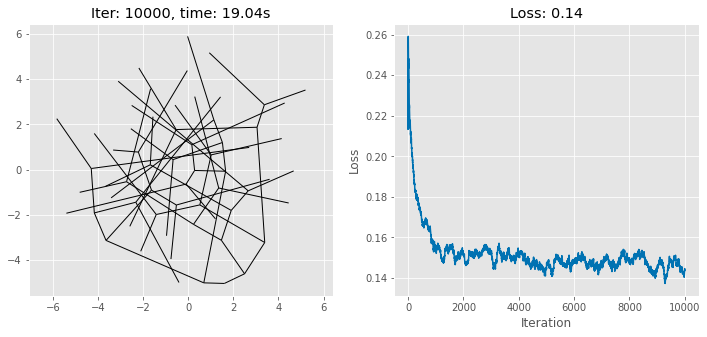

{'gabriel', 'angular_resolution'}



{'stress': 0.37514946939479615, 'edge_uniformity': 0.06103423237800598, 'neighborhood_preservation': 0.8301886767148972, 'crossings': 25, 'crossing_angle_maximization': 0.48547804515544035, 'aspect_ratio': 0.08488237857818604, 'angular_resolution': 0.286440908908844, 'vertex_resolution': 0.8999349575544355, 'gabriel': 0.6453846395015717}


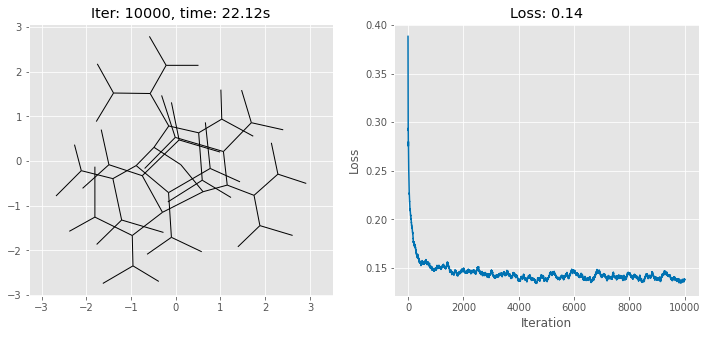

{'vertex_resolution'}



{'stress': 0.5947808462024232, 'edge_uniformity': 7.920380115509033, 'neighborhood_preservation': 0.9836065582931042, 'crossings': 460, 'crossing_angle_maximization': 0.9523807078441141, 'aspect_ratio': 0.13631832599639893, 'angular_resolution': 0.9878459060564637, 'vertex_resolution': 0.2965413613915153, 'gabriel': 0.9797997493296862}


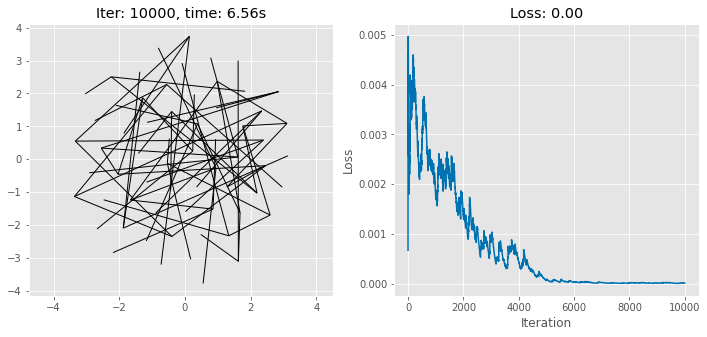

{'gabriel', 'vertex_resolution'}



{'stress': 0.23567832623526738, 'edge_uniformity': 0.1087019145488739, 'neighborhood_preservation': 0.9122807011008263, 'crossings': 20, 'crossing_angle_maximization': 0.46490046862447526, 'aspect_ratio': 0.1647304892539978, 'angular_resolution': 0.7526366263628006, 'vertex_resolution': 0.47499641471627974, 'gabriel': 0.6569750308990479}


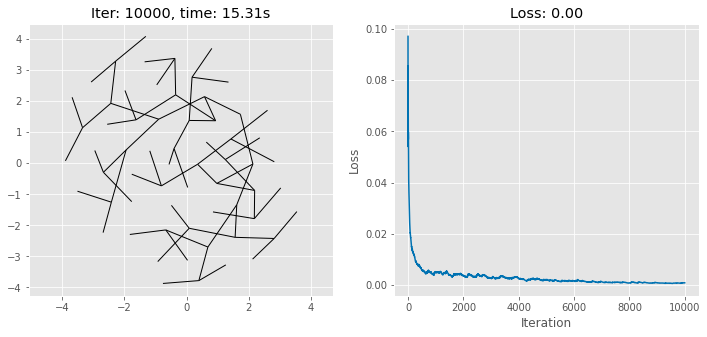

{'gabriel'}



{'stress': 0.6214319651960082, 'edge_uniformity': 0.01126834936439991, 'neighborhood_preservation': 0.9959514169022441, 'crossings': 146, 'crossing_angle_maximization': 0.9985755539306337, 'aspect_ratio': 0.35416632890701294, 'angular_resolution': 0.9997804094309686, 'vertex_resolution': 0.9778953626714582, 'gabriel': 0.15822964906692505}


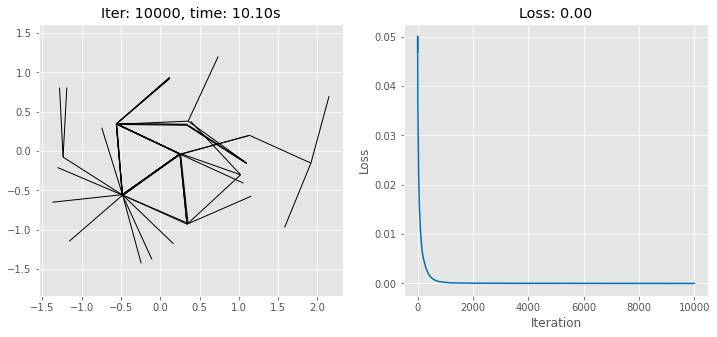

CPU times: user 1h 25min 47s, sys: 10.7 s, total: 1h 25min 58s
Wall time: 30min 47s


In [297]:
%%time


import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2









criteria_weights = dict(
    stress=1,
    edge_uniformity=0.5,
    neighborhood_preservation=0.5,
    crossings=1,
    crossing_angle_maximization=0.1,
    aspect_ratio=10,
    angular_resolution=0.1,
    vertex_resolution=0.05,
    gabriel=0.5,
)

sample_sizes = dict(
    stress=64,
    edge_uniformity=int(len(G)**0.5),
    neighborhood_preservation=16,
    crossings=16,
    crossing_angle_maximization=10,
    aspect_ratio=int(len(G)**0.5),
    angular_resolution=32,
    vertex_resolution=int(len(G)**0.5),
#     vertex_resolution=len(G),
    gabriel=10,
)




## choose criteria
criteria_all = [
    'stress',
    'edge_uniformity',
    'neighborhood_preservation',
    'crossings',
    'crossing_angle_maximization',
    'aspect_ratio',
    'angular_resolution',
    'vertex_resolution',
    'gabriel',
]
for i,c1 in enumerate(criteria_all):
    for c2 in criteria_all[i:]: ##all pairs and singletons
#     for c2 in criteria_all[i+1:]:##all pairs, without singletons
    
        criteria_pair = {c1,c2}
        print(criteria_pair)
        
        gd = GD2(G)

        result = gd.optimize(
            criteria_weights={c:criteria_weights[c] for c in criteria_pair}, 
            sample_sizes=sample_sizes,
            evaluate=criteria_all,

            max_iter=10000, 
            evaluate_interval=10000//40,
            vis_interval=-10000//10,
#             clear_output=True,
            
            optimizer_kwargs = dict(lr=2),
            scheduler_kwargs = dict(verbose=False),
        )
        print(result['qualities'])
        
        pos = gd.pos.detach().numpy()
        pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
        vis.plot(
            gd.G, pos_G,
            gd.loss_curve, 
            result['iter'], result['runtime'],
            edge=True, show=True, save=False
        )
        
        
        
        ## store data
        if c1 == c2:
            fn = c1
        else:
            fn = f'{c1}-vs-{c2}'
        dump(gd, f'{dir_out}/{fn}.pkl')




## plot examples in a matrix

In [43]:
import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2

In [44]:
from matplotlib.gridspec import GridSpec

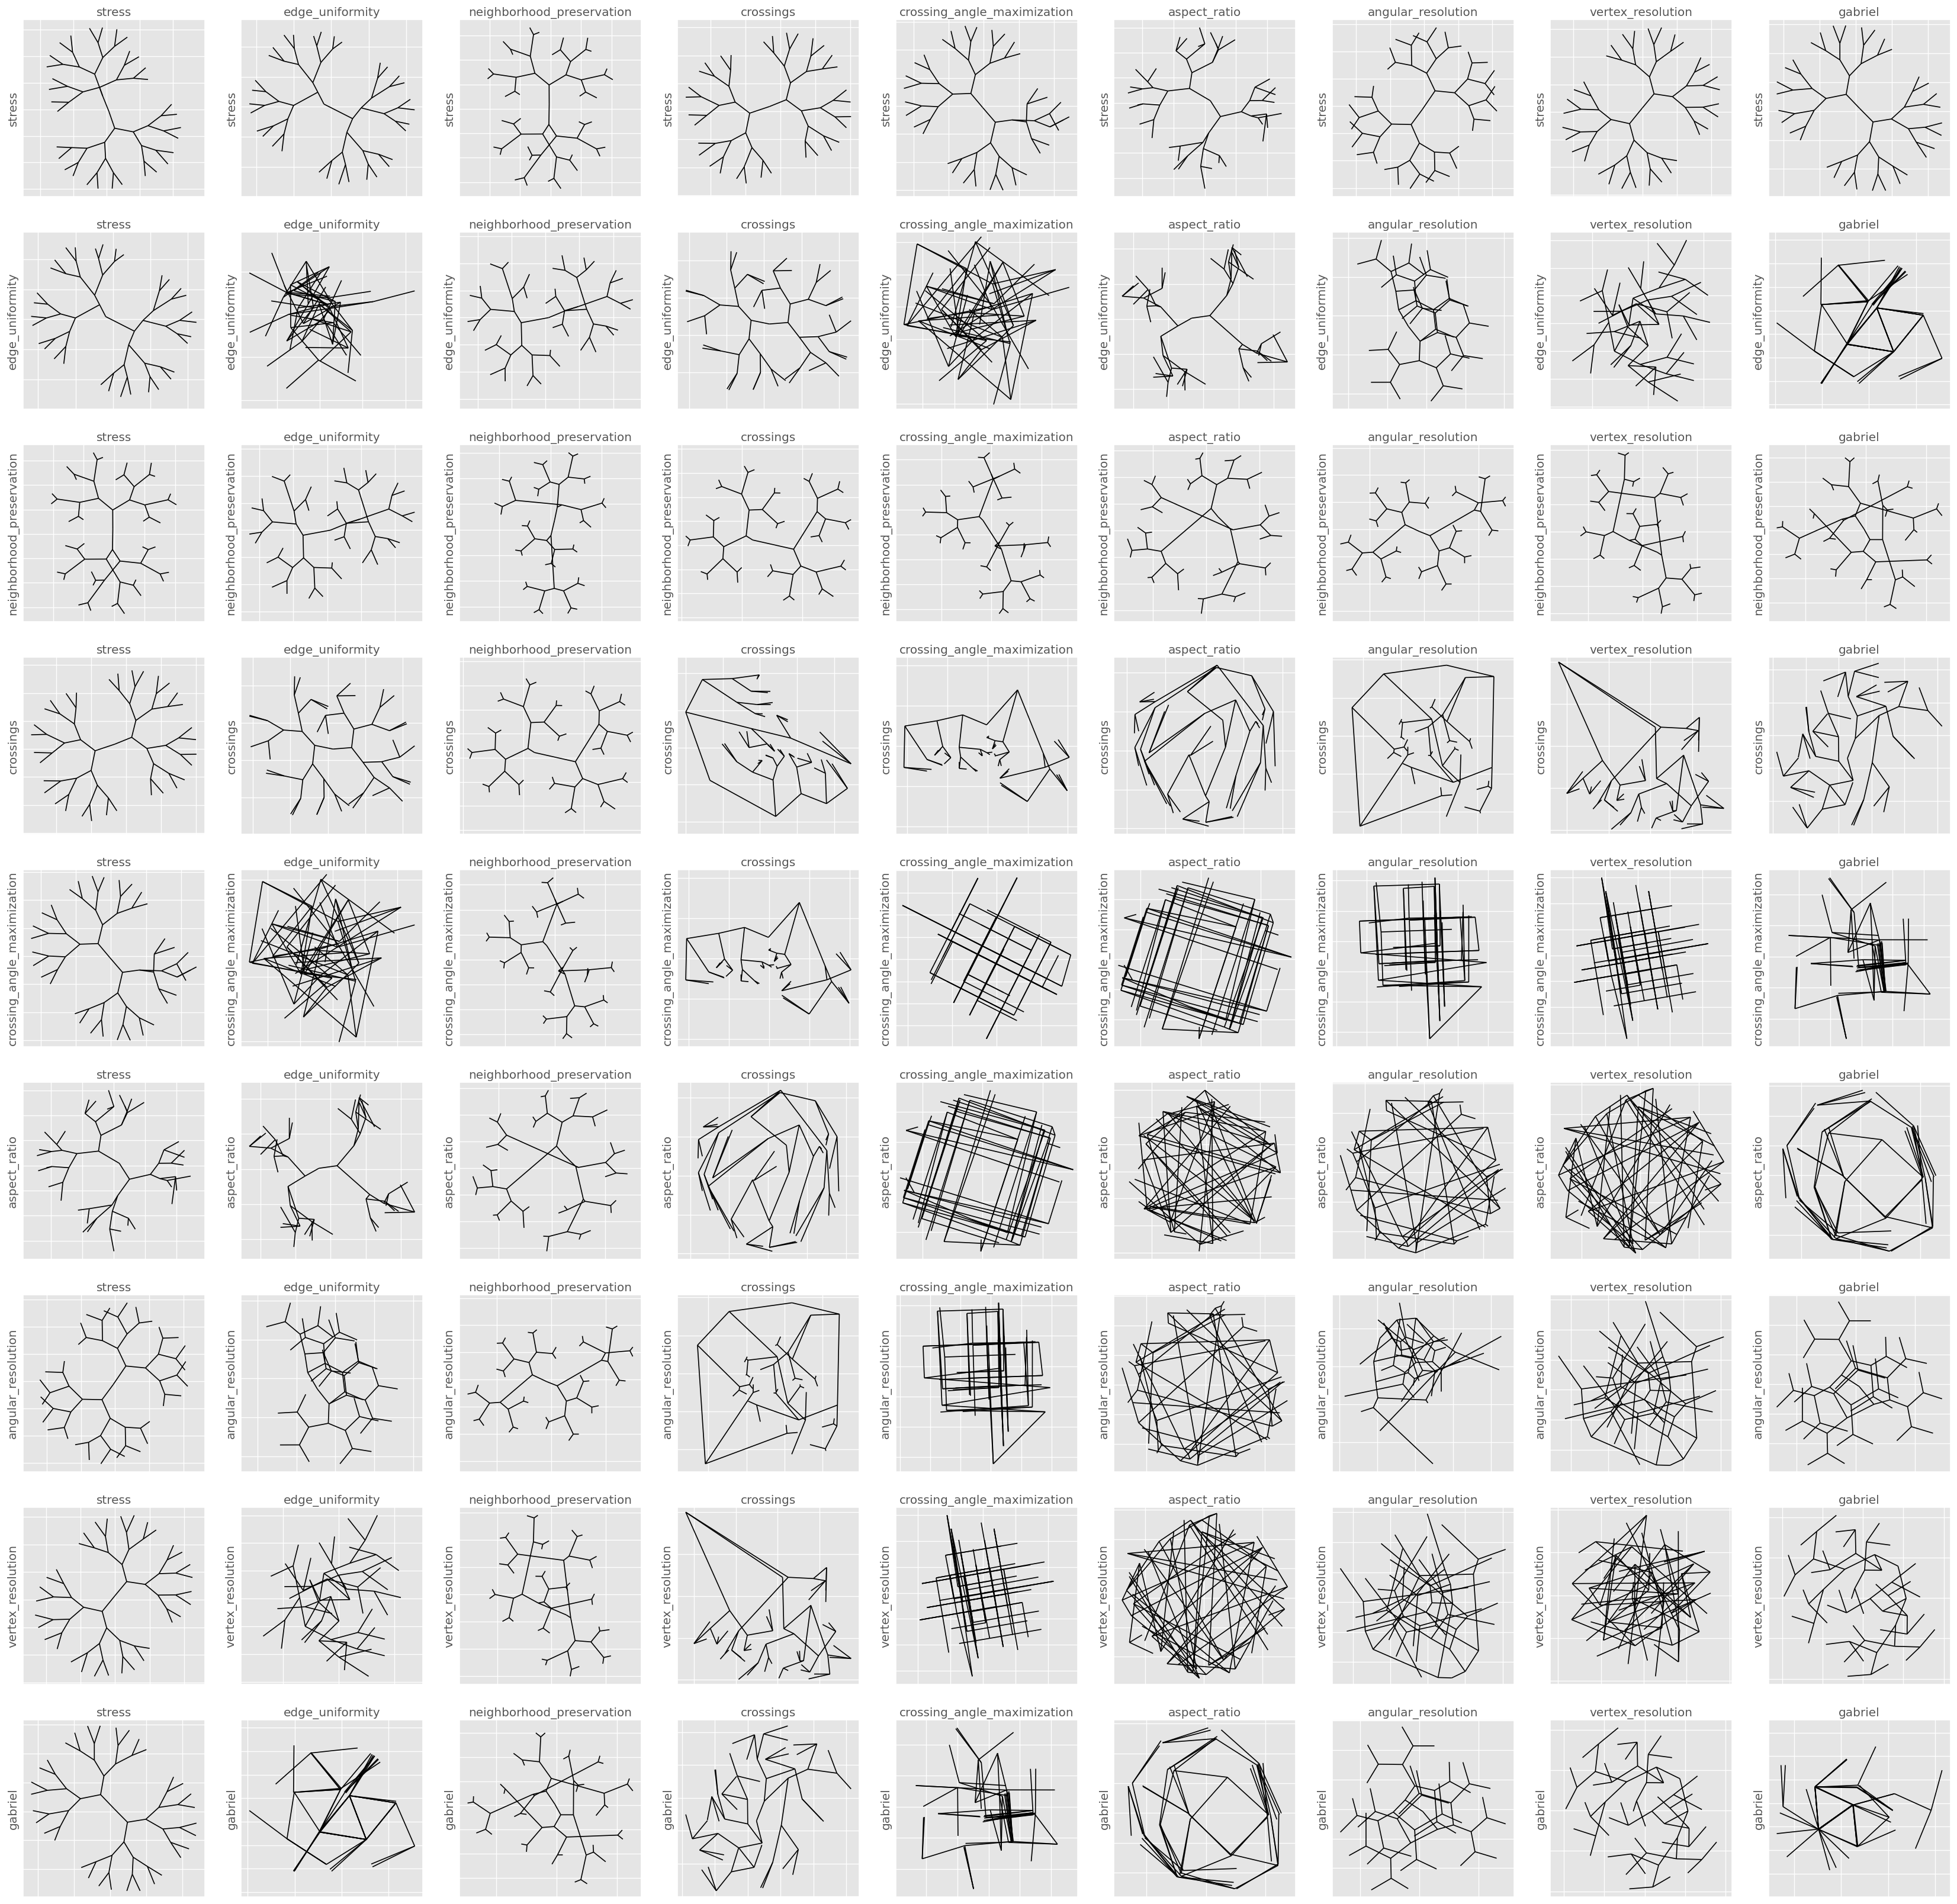

In [298]:
# dir_in = './analysis/criteria_pairs/tree_2_6-0'
# dir_in = './analysis/criteria_pairs/tree_2_5-t1633627830'
dir_in = './analysis/criteria_pairs/tree_2_5-t1633999851'


criteria_all = [
    'stress',
    'edge_uniformity',
    'neighborhood_preservation',
    'crossings',
    'crossing_angle_maximization',
    'aspect_ratio',
    'angular_resolution',
    'vertex_resolution',
    'gabriel',
]
n = len(criteria_all)


# mode = 'criteria_pairs'
mode = 'drawings'
# mode = 'learning_curves'


dpi = 120
if mode == 'drawings':
    space = 0.2
    figsize = [35,35]
else:
    space = 0.3
    figsize = [40,40]
    
fig = plt.figure(figsize=figsize, dpi=dpi)
gs = GridSpec(n,n, wspace=space, hspace=space)


for i,c1 in enumerate(criteria_all):
#     for j,c2 in enumerate(criteria_all[i:],i): ##all pairs and singletons
    for j,c2 in enumerate(criteria_all): ##all pairs and singletons
        
        if c1 == c2:
            fn = c1
        elif i<j:
            fn = f'{c1}-vs-{c2}'
        elif i>j:
            fn = f'{c2}-vs-{c1}'
            
        with open(f'{dir_in}/{fn}.pkl', 'rb') as f:
            data = pkl.load(f)
#             ax = plt.subplot(gs[(n-1)-i,j])
            ax = plt.subplot(gs[i,j])
            
            if mode == 'drawings':
                ## draw graphs
                pos = data['pos'].detach().numpy()
                pos_G = {k:pos[data['k2i'][k]] for k in data['G'].nodes}
                vis.draw_graph(
                    data['G'], pos_G, ax=ax,
                    ylabel=c1,# if j==0 else '',
                    xlabel=c2,# if i==0 else '',
                )
                ax.xaxis.set_label_position('top')
                plt.axis('equal')
                ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            
            
            elif mode == 'criteria_pairs':
                ## plot learn curves
                t = [r['time'] for r in data['qualities_by_time']]
                quality_curve_x = [r['qualities'][c2] for r in data['qualities_by_time']]
                quality_curve_y = [r['qualities'][c1] for r in data['qualities_by_time']]
                plt.scatter(quality_curve_x, quality_curve_y, s=50, c=t)
                plt.xlabel(c2)
                plt.ylabel(c1)
                
                
            elif mode == 'learning_curves':
                ## plot quality curves       
                t = [r['time'] for r in data['qualities_by_time']]
                for c in criteria_all:
                    quality_curve = np.array([r['qualities'][c] for r in data['qualities_by_time']])
                    if c in {'stress', 'crossings', 'edge_uniformity'}:
                        quality_curve = quality_curve/quality_curve.max()
                        
                    if c == c1:
                        color, alpha, style = 'C0', 1.0, '-'
                    elif c == c2:
                        color, alpha, style = 'C1', 1.0, '-'
                    else:
                        color, alpha, style = '#aaa', 1.0, '-'
                    plt.plot(
                        t, quality_curve, 
                        style, 
                        label=c if c==c1 or c==c2 else None,
                        lw=2 if c==c1 or c==c2 else 0.5,
                        color=color,
                        alpha=alpha
                    )
                plt.xlabel('Time')
                plt.ylabel('Quality')
#                 plt.title(f'{c1} vs. {c2}')
                plt.legend()
                plt.ylim([-0.1, 1.5])

t = dir_in.split('-')[-1]
plt.savefig(f'{mode}-matrix-{t}.png', bbox_inches='tight', dpi=dpi)
plt.show()
            


## testing reyans hyper cubes

In [ ]:
import json
log_dir = 'reyan/log_folder/'
problematic_files = ['input_11.txt', 'input_18.txt', 'input_26.txt', 'input_27.txt', 'input_28.txt', 'input_48.txt', 'input_56.txt', 'input_63.txt', 'input_70.txt', 'input_71.txt', 'input_73.txt', 'input_74.txt', 'input_75.txt', 'input_76.txt', 'input_93.txt', 'input_94.txt', 'input_95.txt', 'input_101.txt', 'input_102.txt', 'input_103.txt', 'input_108.txt', 'input_109.txt', 'input_110.txt', 'input_115.txt', 'input_116.txt', 'input_117.txt', 'input_118.txt', 'input_120.txt', 'input_121.txt', 'input_122.txt', 'input_123.txt', 'input_124.txt', 'input_125.txt', 'input_126.txt', 'input_127.txt', 'input_128.txt', 'input_129.txt', 'input_134.txt', 'input_137.txt', 'input_138.txt', 'input_139.txt', 'input_140.txt', 'input_146.txt', 'input_147.txt', 'input_148.txt', 'input_153.txt', 'input_154.txt', 'input_155.txt', 'input_157.txt', 'input_160.txt', 'input_161.txt', 'input_162.txt', 'input_163.txt', 'input_164.txt', 'input_166.txt', 'input_167.txt', 'input_168.txt', 'input_169.txt', 'input_170.txt', 'input_171.txt', 'input_172.txt', 'input_173.txt', 'input_174.txt', 'input_179.txt', 'input_183.txt', 'input_184.txt', 'input_185.txt', 'input_191.txt', 'input_192.txt', 'input_193.txt', 'input_198.txt', 'input_199.txt', 'input_200.txt', 'input_202.txt', 'input_205.txt', 'input_206.txt', 'input_208.txt', 'input_209.txt', 'input_211.txt', 'input_212.txt', 'input_213.txt', 'input_214.txt', 'input_215.txt', 'input_216.txt', 'input_217.txt', 'input_218.txt', 'input_219.txt', 'input_224.txt']
pairs = []
for fn in problematic_files:
    with open(log_dir+fn) as f:
        params = json.load(f)
        graph_str = f'{params["graph"]} {params["graph_param_1"]}'
        pairs.append(
            (tuple(sorted(params['metrics'])),)
            +(graph_str,fn.split('/')[-1].split('.')[0])
        )
        
# for criteria, graph, fn in natsorted(pairs, key=lambda x:x[-1]):
for criteria, graph, fn in natsorted(pairs, key=lambda x:x):
    print(f'{graph}\t{fn:<12} {criteria} ')

In [ ]:
from pathlib import Path

In [ ]:
log_dir = 'log_folder/'
problematic_files = ['input_11.txt', 'input_18.txt', 'input_26.txt', 'input_27.txt', 'input_28.txt', 'input_48.txt', 'input_56.txt', 'input_63.txt', 'input_70.txt', 'input_71.txt', 'input_73.txt', 'input_74.txt', 'input_75.txt', 'input_76.txt', 'input_93.txt', 'input_94.txt', 'input_95.txt', 'input_101.txt', 'input_102.txt', 'input_103.txt', 'input_108.txt', 'input_109.txt', 'input_110.txt', 'input_115.txt', 'input_116.txt', 'input_117.txt', 'input_118.txt', 'input_120.txt', 'input_121.txt', 'input_122.txt', 'input_123.txt', 'input_124.txt', 'input_125.txt', 'input_126.txt', 'input_127.txt', 'input_128.txt', 'input_129.txt', 'input_134.txt', 'input_137.txt', 'input_138.txt', 'input_139.txt', 'input_140.txt', 'input_146.txt', 'input_147.txt', 'input_148.txt', 'input_153.txt', 'input_154.txt', 'input_155.txt', 'input_157.txt', 'input_160.txt', 'input_161.txt', 'input_162.txt', 'input_163.txt', 'input_164.txt', 'input_166.txt', 'input_167.txt', 'input_168.txt', 'input_169.txt', 'input_170.txt', 'input_171.txt', 'input_172.txt', 'input_173.txt', 'input_174.txt', 'input_179.txt', 'input_183.txt', 'input_184.txt', 'input_185.txt', 'input_191.txt', 'input_192.txt', 'input_193.txt', 'input_198.txt', 'input_199.txt', 'input_200.txt', 'input_202.txt', 'input_205.txt', 'input_206.txt', 'input_208.txt', 'input_209.txt', 'input_211.txt', 'input_212.txt', 'input_213.txt', 'input_214.txt', 'input_215.txt', 'input_216.txt', 'input_217.txt', 'input_218.txt', 'input_219.txt', 'input_224.txt']

for fn in problematic_files:
        
    with open(log_dir+fn) as json_file:
        input_param = json.load(json_file)
    
    graph_str = (
        input_param['graph']
        + ' ' 
        + ' '.join(input_param[k] for k in natsorted(input_param) if k.startswith('graph_param_'))
    )
    metrics = input_param['metrics']
    print(f'='*40)
    print(f'fn: {fn}')
    print(f'metrics: {metrics}')
    print(f'graph: {graph_str}')
    
    if Path(input_param["output_file"]).exists():
        continue
          
    print('generating graph', end=' ')
    if input_param["graph"]=="tree":
        G = nx.balanced_tree(int(input_param["graph_param_1"]), int(input_param["graph_param_2"]))
    elif input_param["graph"]=="hypercube":
        G = nx.hypercube_graph(int(input_param["graph_param_1"]))
    elif input_param["graph"]=="grid":
        dim = int(input_param["graph_param_1"])
        G = nx.grid_graph(dim = [dim, dim])
    print(f'of {len(G)} nodes')
    
    max_iter = 10000
    criteria_weights_default = {
        'stress': 4,
        'edge_uniformity':1,
        'neighborhood_preservation':0.5,
        'crossings':1,
        'crossing_angle_maximization':0.1,
        'aspect_ratio':10,
        'angular_resolution':0.1,
        'vertex_resolution':1,
        'gabriel':0.01,
    }

    sample_sizes_default = {
        'stress': 64,
        'edge_uniformity': 10,
        'neighborhood_preservation': 16,
        'crossings': 10,
        'crossing_angle_maximization':10,
        'aspect_ratio': 'full',
        'angular_resolution': 10,
        'vertex_resolution': int(len(G)**0.5),
        'gabriel': 10,
    }


    criteria_weights = {}
    for m in input_param['metrics']:
        criteria_weights[m] = criteria_weights_default[m]


    gd = GD2(G)
    result = gd.optimize(
        criteria_weights=criteria_weights,
        sample_sizes=sample_sizes_default,

        evaluate='all',
    #     evaluate={'neighborhood_preservation'},
#         evaluate=set(input_param['metrics']),

        max_iter=max_iter, 
        evaluate_interval=-1,
        vis_interval=-1,

        optimizer_kwargs = dict(lr=1),
        scheduler_kwargs = dict(verbose=False),
    )


    for q,v in result['qualities'].items():
        print(q,v)

    return_dict = dict(
        metric_value=result['qualities'],
        pos=result['pos'].detach().cpu().tolist(),
        time=result['runtime']
    )
    
    with open(input_param["output_file"], 'w') as fp:
        json.dump(return_dict, fp)
          
          
    ## vis for debugging
    pos = gd.pos.detach().numpy()
    pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
    vis.plot(
        gd.G, pos_G,
        gd.loss_curve, 
        result['iter'], result['runtime'],
        edge=True, show=True, save=False
    )

    

In [ ]:

# from utils import lovasz_losses as L
# a = torch.eye(5)
# pred = torch.randn(5,5)
# L.lovasz_softmax(pred, a)

## Analysis of sample size

In [ ]:
# import importlib
# importlib.reload(C)
# importlib.reload(Q)
# importlib.reload(utils)
# importlib.reload(vis)
# importlib.reload(gd2)

In [ ]:
import pandas as pd
import itertools

In [ ]:
df

In [ ]:
# cm = plt.cm.viridis()

# for result in results:
    
#     sample_size = result['sample_sizes']['stress']
    
#     t = [x['time'] for x in result['qualities_by_time']]
#     stress = [x['qualities']['stress'] for x in result['qualities_by_time']]
    
#     plt.plot(t, stress, '.-', label=f'sample_size = {sample_size}', color=cm(np.log2(sample_size)/np.log2(512)))
    
# plt.xlabel('Total Time (sec)')
# plt.ylabel('Stress')
# plt.yscale('log')

# plt.xlim([-10,100])
# plt.legend()
# plt.savefig('time-vs-stress-curve-by-sample-size-100sec.png')
# plt.show()

In [ ]:
# df.to_csv('./analysis/balanced-tree-2-8.csv')

In [ ]:
df.plot('sample_size', 'runtime', style='o')
df.plot('sample_size', 'stress', style='o');

In [ ]:
plt.scatter(
    df['runtime'], 
    df['stress'], 
    s=df['sample_size']+10, 
    linewidth=1,
    edgecolor='#eee',
    alpha=0.8,
#     c=df['sample_size']+10,
    label='Sample Size',
)

# plt.xscale('symlog')
plt.xlabel('Runtime')
plt.xlim([0, plt.xlim()[1]*1.1])

# plt.yscale('log')
plt.ylabel('Stress')
plt.ylim([0, plt.ylim()[1]*1.1])

plt.savefig('figures-tmp/runtime-vs-stress-by-sample_rate.png')

## Dev

In [ ]:
%%time


import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)


runtime = []

niter = int(1e6)

shouldVis = True
visIter = 5000

shouldSnap = True
snapIter = 5

gClamp = 4
minLR = 1e-5
maxSampleSize = 64


totalTime = 0

print('generating graph', end=' ')
# G = nx.grid_2d_graph(18,36)
# G = nx.hypercube_graph(3)
# G = nx.balanced_tree(2,4)
G = utils.load_spx_teaser()
# G = nx.karate_club_graph()


# graph_name = 'grid1'
# graph_name = 'grid1_dual'
# graph_name = 'odepa400'
# graph_name = 'netz4504_dual'
# graph_name = 'L'
# -----
# graph_name = 'netz4504'
# graph_name = 'qh882'
# mat_dir = 'graphs/SuiteSparse Matrix Collection'
# G = utils.load_mat(f'{mat_dir}/{graph_name}.mat')


# G = nx.Graph()
# G.add_nodes_from([0,1,2,3])
# G.add_edges_from([(0,1),(2,3)])




print(f'of {len(G)} nodes')
maxDegree = max(dict(G.degree).values())
print('Calculating all pairs shortest path', end='...')
t0 = time.time()

# D, k2i = utils.dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
# adj,_ = utils.dict2tensor(dict(G.adjacency()), fill=1, device=device)
D, adj_sparse, k2i = utils.shortest_path(G)
adj = torch.from_numpy(adj_sparse.toarray())
D = torch.from_numpy(D)

i2k = {i:k for k,i in k2i.items()}
edge_indices = [(k2i[e0], k2i[e1]) for e0,e1 in G.edges]
node_indices = range(len(G))
node_index_pairs = np.c_[
    np.repeat(node_indices, len(G)),
    np.tile(node_indices, len(G))
]
node_index_pairs_start = 0
np.random.shuffle(node_index_pairs)


    
dt = time.time() - t0
totalTime += dt

W = 1/(D**2+1e-6)
truth = adj + torch.eye(adj.shape[0], device=device)
print('done')


##training
#     pos = torch.rand(len(G.nodes), 2, device=device)*2-1
pos = torch.randn(len(G.nodes), 2, device=device)
pos.requires_grad_(True)


##LOAD prev layout
# G_ = nx.read_gpickle(glob(f'layouts/balanced_tree_{2}_{7}-stress-*.gpickle')[0])
# pos = {k2i[k]: G_.nodes[k]['pos'] for k in G_.nodes}
# pos = torch.stack([torch.from_numpy(pos[i]) for i in range(len(pos))])
# pos = pos.requires_grad_(True)


optimizer = optim.SGD([pos], lr=0.1, momentum=0.7, nesterov=True)
# optimizer = optim.RMSprop([pos], lr=0.01)
# optimizer = optim.Adam([pos], lr=0.001)


# scheduler = None
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.9, patience=np.ceil(np.log2(len(G)+1))*100, 
    min_lr=minLR, verbose=True
)
# scheduler = optim.lr_scheduler.LambdaLR(
#     optimizer, 
#     lr_lambda=lambda e:1*(1-e/niter)
# )


iterBar = tqdm(range(niter))
lossCurve = []
sampleSize = min(len(G), maxSampleSize)
degrees = adj.sum(1).numpy().astype(np.int64)
xPath = []

qualityMeasureInterval = max(1, niter // 30)
qualityMeasureCurves = defaultdict(list)
activeQualityMeasures = [
    'stress',
#     'edge_uniformity',
#     'neighborhood_preservation',
#     'crossings',
    
#     'crossing_angle_maximization',
    'aspect_ratio',
#     'angular_resolution',
#     'vertex_resolution',
#     'gabriel',
    
]

for i in iterBar:
    t0 = time.time()
    
    ## optimization
    optimizer.zero_grad()

    if node_index_pairs_start >= len(node_index_pairs):
        np.random.shuffle(node_index_pairs)
        node_index_pairs_start = 0
    stress_samples = node_index_pairs[node_index_pairs_start:node_index_pairs_start+sampleSize]
    
    loss = (
        +C.stress(pos, D, W, samples=stress_samples)
#         +0.5*C.edge_uniformity(pos, G, k2i, sampleSize-1)
#         +0.1*C.angular_resolution(pos, G, k2i, sampleSize=sampleSize//maxDegree)
#         + 10*C.aspect_ratio(pos, sampleSize)
#         C.crossing_angle_maximization(pos, G, k2i, i2k, sampleSize=10, sampleOn='crossings') ## slow for large sample size
#     +0.001*C.vertex_resolution(pos, sampleSize, target=1/len(G)**0.5)
#     + 0.1*C.gabriel(pos, G, k2i, sampleSize=int(sampleSize**0.5))
#         +1*C.crossings(pos, G, k2i, reg_coef=0.01, niter=20, sampleSize=4, sampleOn='crossings')
#         +C.crossings(pos, G, k2i, reg_coef=0.01, niter=20, sampleSize=20, sampleOn='edges')
#         C.neighborhood_preseration(pos, G, adj, k2i, i2k, n_roots=2, depth_limit=2)
    )
    loss.backward()
    pos.grad.clamp_(-gClamp, gClamp)
    optimizer.step()
    
    node_index_pairs_start+=sampleSize
    
    ## debug info
    totalTime += time.time() - t0
    if loss.isnan():
        raise Exception('loss is nan')
    if pos.isnan().any():
        raise Exception('pos is nan')
    
    if i % int(niter/100) == int(niter/100)-1:
        iterBar.set_postfix({'loss': loss.item(), })    
    if len(lossCurve) > 0:
        lossCurve.append(0.9*lossCurve[-1] + 0.1*loss.item())
    else:
        lossCurve.append(loss.item())
    if shouldSnap and i % snapIter == 0:
        x = pos.detach().cpu().numpy()
        xPath.append(x.copy())    
    
    
    ## quality measures
    if i % qualityMeasureInterval == qualityMeasureInterval-1:
        if 'stress' in activeQualityMeasures:
            qualityMeasureCurves['stress'].append(
                Q.stress(pos, D, W, None)
            )
        if 'edge_uniformity' in activeQualityMeasures:
            qualityMeasureCurves['edge_uniformity'].append(
                Q.edge_uniformity(pos, G, k2i)
            )
        if 'neighborhood_preservation' in activeQualityMeasures:
            qualityMeasureCurves['neighborhood_preservation'].append(
                Q.neighborhood_preservation(pos, G, adj, i2k)
            )
        if 'crossings' in activeQualityMeasures:
            qualityMeasureCurves['crossings'].append(
                Q.crossings(pos, edge_indices)
            )
        if 'crossing_angle_maximization' in activeQualityMeasures:
            qualityMeasureCurves['crossing_angle_maximization'].append(
                Q.crossing_angle_maximization(pos, G.edges, k2i)
            )
        if 'aspect_ratio' in activeQualityMeasures:
            qualityMeasureCurves['aspect_ratio'].append(
                Q.aspect_ratio(pos)
            )
        if 'angular_resolution' in activeQualityMeasures:
            qualityMeasureCurves['angular_resolution'].append(
                Q.angular_resolution(pos, G, k2i)
            )
            
        if 'vertex_resolution' in activeQualityMeasures:
            qualityMeasureCurves['vertex_resolution'].append(
                Q.vertex_resolution(pos, target=1/len(G)**0.5)
            )
        if 'gabriel' in activeQualityMeasures:
            qualityMeasureCurves['gabriel'].append(
                Q.gabriel(pos, G, k2i)
            )
        

    ##vis
    if shouldVis and i % visIter == visIter-1:
        x = pos.detach().cpu().numpy()
        pos_i = {k: x[k2i[k], :2] for k in G.nodes}
        display.clear_output(wait=True)
        vis.plot(G, pos_i, lossCurve, [], i, totalTime, node_size=6, edge=True, show=True, save=False)
    
        
    
    if scheduler is not None:
#         scheduler.step(i)
        scheduler.step(lossCurve[-1])
    

    if optimizer.param_groups[0]['lr'] <= minLR:
#     or pos.grad.max() < 1e-3*(pos.max()-pos.min()):
        print('Done')
        break

In [ ]:
# show final result
x = pos.detach().cpu().numpy()
pos_i = {k: x[k2i[k], :2] for k in G.nodes}
vis.plot(G, pos_i, lossCurve, [], i, totalTime,  
         show=True, save=False, title=f'|V|={len(G)}, iter: {i}, time: {totalTime:.2f} sec')
totalTime

In [ ]:
for q in activeQualityMeasures:
    plt.figure(figsize=[6,3])
    plt.plot(qualityMeasureCurves[q],'.-')
    plt.ylabel(' '.join(s.capitalize() for s in q.split('_')))
    plt.title(' '.join(s.capitalize() for s in q.split('_')))
    plt.show()
    print(qualityMeasureCurves[q])

In [ ]:
1/len(G)**0.5

In [ ]:
# fig, ax = plt.subplots()

# nx.draw_networkx(G, pos_i, ax=ax)
# ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


## Animation

In [ ]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# if type(xPath) == list:
#     xPath = np.stack(xPath)
    
# padding = 0.1

# fig, ax = plt.subplots()
# scatter = plt.scatter([0], [0], s=10)
# lc = mc.LineCollection([], linewidths=1)
# ax.add_collection(lc)

# xlim = [np.min(xPath[:,:,0]),np.max(xPath[:,:,0])]
# ylim = [np.min(xPath[:,:,1]),np.max(xPath[:,:,1])]
# xlim = [xlim[0]-padding*(xlim[1]-xlim[0]), xlim[1]+padding*(xlim[1]-xlim[0])]
# ylim = [ylim[0]-padding*(ylim[1]-ylim[0]), ylim[1]+padding*(ylim[1]-ylim[0])]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
    
# def init():
#     return scatter,lc

# def update(frame):
#     xy = xPath[frame]
#     scatter.set_offsets(xy)
#     segs = [[xy[k2i[k0]], xy[k2i[k1]]] for k0,k1 in G.edges]           
#     lc.set_segments(segs)
#     return scatter,lc

# anim = FuncAnimation(
#     fig, 
#     update, 
#     frames=range(0,len(xPath),1),
#     init_func=init, 
#     interval=1000.0/20,
#     blit=True)

# HTML(anim.to_jshtml())

In [ ]:
# x = pos.detach().cpu().numpy()
# pos_i = {k: x[k2i[k], :2] for k in G.nodes}
# vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)

## animation

In [ ]:
# # Create a gif from images in fig/
# # 
# frames = []
# imgs = natsorted(glob('fig/*.png'))

# for img in imgs:
#     new_frame = Image.open(img)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=100, loop=0)